<a href="https://colab.research.google.com/github/ksuszko/linkedin/blob/master/Stance_detection_wfh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Fine-Tuning Tutorial with PyTorch

In [ ]:

import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

RuntimeError: ignored

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
!pip install transformers

     |████████████████████████████████| 778kB 6.5MB/s 
     |████████████████████████████████| 3.0MB 12.8MB/s 
     |████████████████████████████████| 890kB 60.8MB/s 
     |████████████████████████████████| 1.1MB 58.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=452b7530353e701d5690e0fafe1adc4145e23bc808d934dd294ab34fcea08a23
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import csv
from collections import defaultdict
posts = []
targets = []
stances = []

with open('train.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            #print(f'\t{row[0]} works in the {row[1]} department, and was born in {row[2]}.')
            line_count += 1
            print(line_count)
            post, stance, target = row
            posts.append(post)
            targets.append(target)
            stances.append(stance)
            #sentiments.append(sentiment)
    print(f'Processed {line_count} lines.')

# Get the lists of sentences and their labels.
target_set = ['WFH']
stance_set = ['AGAINST', 'NEUTRAL', 'FOR','UNRELATED']
#sentiment_set =set(sentiments)


target_dict = {t:i for i,t in enumerate(target_set)}
stance_dict = {st:i for i,st in enumerate(stance_set)}
#sentiment_dict = {se:i for i,se in enumerate(sentiment_set)}

print(target_dict)
print(stance_dict)
#print(sentiment_dict)


target_labels = []
stance_labels = []
#sentiment_labels = []

for i, l in enumerate(posts):
  target_labels.append(target_dict[targets[i]])
  stance_labels.append(stance_dict[stances[i]])
 # sentiment_labels.append(sentiment_dict[sentiments[i]])


Column names are Posts, Stance, Target
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268

# 3. Tokenization & Input Formatting


In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Let's apply the tokenizer to one sentence just to see the output.


In [ ]:
# Print the original sentence.
print(' Original: ', posts[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(posts[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(posts[0])))

 Original:  I teach general ed, grade 4/5 in Colorado and my school has completed 3 days of remote learning and we're continuing until April 17 (at least). After Spring Break we'll have Mondays to do professional development & planning and it'll be a "catch-up" day for students. Tuesday-Friday we'll do remote teaching/learning. We haven't been give many expectations as far as how much work we should assign to students, if we should assign work from all subjects or not, or what our "office hours" should be. Don't get me wrong - I appreciate not being micromanaged :). However, I'm curious to hear what expectations other educators with similar roles  are receiving from their admin regarding remote learning.
Tokenized:  ['i', 'teach', 'general', 'ed', ',', 'grade', '4', '/', '5', 'in', 'colorado', 'and', 'my', 'school', 'has', 'completed', '3', 'days', 'of', 'remote', 'learning', 'and', 'we', "'", 're', 'continuing', 'until', 'april', '17', '(', 'at', 'least', ')', '.', 'after', 'spring', 

## 3.2. Sentences to IDs

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.

def convert_examples_to_features(tweets, max_length = 128, pad_token=0):
  input_ids = []
  attention_masks = []
  token_type_ids = []
  labels = []
  # For every sentence...
  for text in posts:
      #text_a = sentences_1[i]
      #text_b = sentences_2[i]
      # `encode` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      inputs = tokenizer.encode_plus(
                          text,  
                          truncation = True ,                   # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        
                          # This function also supports truncation and conversion
                          # to pytorch tensors, but we need to do padding, so we
                          # can't use these features :( .
                          max_length = max_length,          # Truncate all sentences.
                          #return_tensors = 'pt',     # Return pytorch tensors.
                    )
      # Add the encoded sentence to the list.
      input_id, token_type_id = inputs["input_ids"], inputs["token_type_ids"]
      


      # The mask has 1 for real tokens and 0 for padding tokens. Only real
      # tokens are attended to.
      attention_mask = [1] * len(input_id)

      # Zero-pad up to the sequence length.
      padding_length = max_length - len(input_id)

      input_id = input_id + ([pad_token] * padding_length)
      attention_mask = attention_mask + ([0] * padding_length)
      token_type_id = token_type_id + ([0] * padding_length)

      input_ids.append(input_id)
      attention_masks.append(attention_mask)
      token_type_ids.append(token_type_id)
  
  return input_ids, attention_masks, token_type_ids





input_ids, attention_masks, token_type_ids = convert_examples_to_features(posts, max_length = 256, pad_token=0)

## 3.5. Training & Validation Split


Divide up our training set to use 90% for training and 10% for validation.

In [ ]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_target_labels, validation_target_labels = train_test_split(input_ids, target_labels, 
                                                            random_state=2018, test_size=0.1)
train_stance_labels, validation_stance_labels = train_test_split(stance_labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, train_token_type_ids, validation_token_type_ids= train_test_split(attention_masks, token_type_ids,
                                             random_state=2018, test_size=0.1)

## 3.6. Converting to PyTorch Data Types

Our model expects PyTorch tensors rather than numpy.ndarrays, so convert all of our dataset variables.

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_target_labels = torch.tensor(train_target_labels)
validation_target_labels = torch.tensor(validation_target_labels)
train_stance_labels = torch.tensor(train_stance_labels)
validation_stance_labels = torch.tensor(validation_stance_labels)
#train_sentiment_labels = torch.tensor(train_sentiment_labels)
#validation_sentiment_labels = torch.tensor(validation_sentiment_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

train_token_type_ids = torch.tensor(train_token_type_ids)
validation_token_type_ids = torch.tensor(validation_token_type_ids)

We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_token_type_ids, 
                           train_target_labels, train_stance_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_token_type_ids, 
                                validation_target_labels, validation_stance_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [ ]:
PYTORCH_PRETRAINED_BERT_CACHE = './pretrained'

In [ ]:
! pip install transformers

# 4. Train Our Classification Model

In [ ]:
""" XXX model configuration """

import logging

from transformers import PretrainedConfig


logger = logging.getLogger(__name__)

XXX_PRETRAINED_CONFIG_ARCHIVE_MAP = {
    "xxx-base-uncased": "https://s3.amazonaws.com/models.huggingface.co/bert/xxx-base-uncased-config.json",
    "xxx-large-uncased": "https://s3.amazonaws.com/models.huggingface.co/bert/xxx-large-uncased-config.json",
}


class XxxConfig(PretrainedConfig):
    r"""
        :class:`~transformers.XxxConfig` is the configuration class to store the configuration of a
        `XxxModel`.
        Arguments:
            vocab_size: Vocabulary size of `inputs_ids` in `XxxModel`.
            hidden_size: Size of the encoder layers and the pooler layer.
            num_hidden_layers: Number of hidden layers in the Transformer encoder.
            num_attention_heads: Number of attention heads for each attention layer in
                the Transformer encoder.
            intermediate_size: The size of the "intermediate" (i.e., feed-forward)
                layer in the Transformer encoder.
            hidden_act: The non-linear activation function (function or string) in the
                encoder and pooler. If string, "gelu", "relu", "swish" and "gelu_new" are supported.
            hidden_dropout_prob: The dropout probabilitiy for all fully connected
                layers in the embeddings, encoder, and pooler.
            attention_probs_dropout_prob: The dropout ratio for the attention
                probabilities.
            max_position_embeddings: The maximum sequence length that this model might
                ever be used with. Typically set this to something large just in case
                (e.g., 512 or 1024 or 2048).
            type_vocab_size: The vocabulary size of the `token_type_ids` passed into
                `XxxModel`.
            initializer_range: The sttdev of the truncated_normal_initializer for
                initializing all weight matrices.
            layer_norm_eps: The epsilon used by LayerNorm.
    """
    pretrained_config_archive_map = XXX_PRETRAINED_CONFIG_ARCHIVE_MAP
    model_type = "xxx"

    def __init__(
        self,
        vocab_size=50257,
        n_positions=1024,
        n_ctx=1024,
        n_embd=768,
        n_layer=12,
        n_head=12,
        resid_pdrop=0.1,
        embd_pdrop=0.1,
        attn_pdrop=0.1,
        layer_norm_epsilon=1e-5,
        initializer_range=0.02,
        summary_type="cls_index",
        summary_use_proj=True,
        summary_activation=None,
        summary_proj_to_labels=True,
        summary_first_dropout=0.1,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.n_ctx = n_ctx
        self.n_positions = n_positions
        self.n_embd = n_embd
        self.n_layer = n_layer
        self.n_head = n_head
        self.resid_pdrop = resid_pdrop
        self.embd_pdrop = embd_pdrop
        self.attn_pdrop = attn_pdrop
        self.layer_norm_epsilon = layer_norm_epsilon
        self.initializer_range = initializer_range
        self.summary_type = summary_type
        self.summary_use_proj = summary_use_proj
        self.summary_activation = summary_activation
        self.summary_first_dropout = summary_first_dropout
        self.summary_proj_to_labels = summary_proj_to_labels

    @property
    def max_position_embeddings(self):
        return self.n_positions

    @property
    def hidden_size(self):
        return self.n_embd

    @property
    def num_attention_heads(self):
        return self.n_head

    @property
    def num_hidden_layers(self):
        return self.n_layer
config = XxxConfig()

In [ ]:
from transformers import BertTokenizer, WordpieceTokenizer
from transformers import BertForPreTraining, BertPreTrainedModel, BertModel, BertConfig, BertForMaskedLM, BertForSequenceClassification
from pathlib import Path
import re
from torch import Tensor
from torch.nn import BCEWithLogitsLoss
from fastai.text import Tokenizer, Vocab
import pandas as pd
import collections
import os
import pdb
from tqdm import tqdm, trange
import sys
import random
import numpy as np
#import apex
from sklearn.model_selection import train_test_split
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sklearn.metrics import roc_curve, auc


from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
import torch.nn as nn
#from pytorch_pretrained_bert.optimization import BertAdam

In [ ]:
z = torch.FloatTensor([[1,2,3],[4,5,6],[7,8,9]])
torch.stack([z]*3,dim=0)

tensor([[[1., 2., 3.],
         [4., 5., 6.],
         [7., 8., 9.]],

        [[1., 2., 3.],
         [4., 5., 6.],
         [7., 8., 9.]],

        [[1., 2., 3.],
         [4., 5., 6.],
         [7., 8., 9.]]])

In [ ]:
import math
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model=768, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)




class BertForMultiLabel(nn.Module):
    """BERT model for classification.
    This module is composed of the BERT model with a linear layer on top of
    the pooled output.
    Params:
        `config`: a BertConfig class instance with the configuration to build a new model.
        `num_labels`: the number of classes for the classifier. Default = 2.
    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary(see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `labels`: labels for the classification output: torch.LongTensor of shape [batch_size]
            with indices selected in [0, ..., num_labels].
    Outputs:
        if `labels` is not `None`:
            Outputs the CrossEntropy classification loss of the output with the labels.
        if `labels` is `None`:
            Outputs the classification logits of shape [batch_size, num_labels].
    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 1, 0]])
    config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)
    num_labels = 2
    model = BertForSequenceClassification(config, num_labels)
    logits = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, num_targets=5, num_stances=3):
        super(BertForMultiLabel, self).__init__()
        config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)

        self.att_dim = 768
        self.heads = 12

        self.bert = BertModel.from_pretrained(
            "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
            output_attentions = False, # Whether the model returns attentions weights.
            output_hidden_states=True)
        self.config = self.bert.config
        self.num_targets = num_targets
        self.num_stances = num_stances

        self.target_embedding = nn.Embedding(num_targets, self.att_dim)
        self.stance_embedding = nn.Embedding(num_stances, self.att_dim)
        
        self.pe = PositionalEncoding(self.att_dim, 0.1)


        self.mlthead_attn_0 = nn.MultiheadAttention( self.att_dim, self.heads, dropout=0.1)
        self.mlthead_attn_1 = nn.MultiheadAttention( self.att_dim, self.heads, dropout=0.1)
        self.mlthead_attn_2 = nn.MultiheadAttention( self.att_dim, self.heads, dropout=0.1)
        self.mlthead_attn_3 = nn.MultiheadAttention( self.att_dim, self.heads, dropout=0.1)

        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        self.dropout2 = torch.nn.Dropout(2*config.hidden_dropout_prob)
        self.target_classifier = torch.nn.Linear(2*config.hidden_size, num_targets)
        self.stance_classifier = torch.nn.Linear(2*config.hidden_size, num_stances)
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, target_labels=None, stance_labels=None):
        
        sequence_output, pooled_output, hidden_states = self.bert(input_ids, token_type_ids, attention_mask)
        #print(len(hidden_states))  # 13

        pooled_output = self.dropout(pooled_output)
        
        #print(logits.shape)
        #print("seq output",sequence_output.shape)
        #print("target_labels",target_labels)

        if stance_labels is not None:
            queries = torch.cat([self.target_embedding(target_labels.to(device).long()),
                                   pooled_output ],
                                dim=-1)
            #print("queries: ", queries.shape)
            #queries = self.dropout2(queries)
            #attn_output_0, attn_output_weights_0 = self.mlthead_attn_0(
            #    queries, queries, queries) #, attn_mask=np_mask
            #print("att out: ", attn_output_0.shape)
            #attn_output_0 += queries
            #target_logits = self.target_classifier(torch.cat(
            #    [attn_output_0[:,0,:],attn_output_0[:,1,:]],dim=1))
            target_logits = self.target_classifier(queries)
            stance_logits = self.stance_classifier(queries)
            #target_logits = self.target_classifier(pooled_output)
            #stance_logits = self.stance_classifier(pooled_output)
            # get attn_output_0[:,0,:] to slice the first half of the data

            loss_fct = nn.CrossEntropyLoss() #BCEWithLogitsLoss()

            
            target_loss = loss_fct(target_logits.view(-1, self.num_targets), target_labels.flatten())
            stance_loss = loss_fct(stance_logits.view(-1, self.num_stances), stance_labels.flatten())
            #print(self.target_embedding(torch.Tensor([0,1,2,3,4]).to(device).long()))
            return stance_loss + target_loss
        else:
            queries = torch.cat([self.target_embedding(target_labels.to(device).long()),
                                   pooled_output ],
                                dim=-1)
            #print("queries: ", queries.shape)

            target_logits = self.target_classifier(queries)
            stance_logits = self.stance_classifier(queries)
            #target_logits = self.target_classifier(pooled_output)
            #stance_logits = self.stance_classifier(pooled_output)

            #print(stance_logits)
            return target_logits, stance_logits
        
    def freeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = False
    
    def unfreeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = True

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertModel

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForMultiLabel(num_targets=5, num_stances=3)
# Tell pytorch to run this model on the GPU.
model.cuda()

BertForMultiLabel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())


In [ ]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
print(input)
target = torch.empty(3, dtype=torch.long).random_(5)
print(target)
output = loss(input, target)
print(output)
output.backward()

tensor([[-1.0198,  1.8558,  0.2884,  2.5007,  0.5402],
        [-0.1169,  1.5240, -1.1129, -0.7214,  1.4016],
        [ 1.0365,  1.1815, -1.2981,  1.2831, -0.6237]], requires_grad=True)
tensor([4, 4, 3])
tensor(1.5182, grad_fn=<NllLossBackward>)


## 4.2. Optimizer & Learning Rate Scheduler

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 6

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times.


In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
print(train_dataloader)

We're ready to kick off the training!

In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_token_type_ids = batch[2].to(device)
        b_target_labels = batch[3].to(device)
        b_stance_labels = batch[4].to(device)
        

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=b_token_type_ids, 
                    attention_mask=b_input_mask, 
                    target_labels=b_target_labels,
                    stance_labels=b_stance_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        
        loss = outputs

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, stance_eval_accuracy, target_eval_accuracy = 0, 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_token_type_ids,b_target_labels, b_stance_labels = batch[:5]
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids= b_token_type_ids, 
                            attention_mask=b_input_mask,
                            target_labels=b_target_labels)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        target_logits = outputs[0]
        stance_logits = outputs[1]

        # Move logits and labels to CPU
        target_logits = target_logits.detach().cpu().numpy()
        stance_logits = stance_logits.detach().cpu().numpy()
        target_label_ids = b_target_labels.cpu().numpy()
        stance_label_ids = b_stance_labels.cpu().numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        target_tmp_eval_accuracy = flat_accuracy(target_logits, target_label_ids)
        stance_tmp_eval_accuracy = flat_accuracy(stance_logits, stance_label_ids)
        # Accumulate the total accuracy.
        target_eval_accuracy += target_tmp_eval_accuracy
        stance_eval_accuracy += stance_tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Target Accuracy: {0:.2f}".format(target_eval_accuracy/nb_eval_steps))
    print("  Stance Accuracy: {0:.2f}".format(stance_eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")

NameError: ignored

Let's take a look at our training loss over all batches:

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


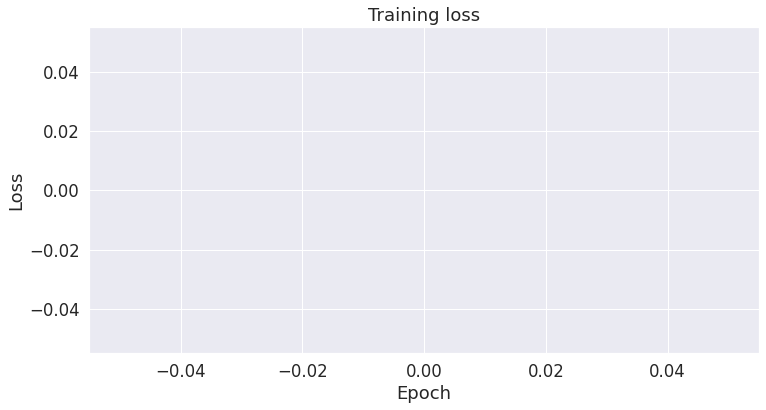

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.savefig('loss.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Performance On Test Set

In [ ]:
import csv
test_posts = []
test_targets = []
test_stances = []

with open('test.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            line_count += 1
            #print(line_count)
            post, target, stance = row
            if target != 'Donald Trump':
                test_posts.append(post)
                test_targets.append(target)
                test_stances.append(stance)
                #test_sentiments.append(sentiment)
    print(f'Processed {line_count} lines.')



test_target_labels = []
test_stance_labels = []
#test_sentiment_labels = []

for i, l in enumerate(test_posts):
    test_target_labels.append(target_dict[test_targets[i]])
    test_stance_labels.append(stance_dict[test_stances[i]])
    #test_sentiment_labels.append(sentiment_dict[test_sentiments[i]])


Column names are Posts, Stance, Target
Processed 201 lines.


KeyError: ignored

In [ ]:
import pandas as pd

# Tokenize all of the sentences and map the tokens to thier word IDs.

def convert_examples_to_features(test_posts, max_length = 128, pad_token=0):
  input_ids = []
  attention_masks = []
  token_type_ids = []
  labels = []
  # For every sentence...
  for text in test_tweets:
      #text_a = sentences_1[i]
      #text_b = sentences_2[i]
      # `encode` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      inputs = tokenizer.encode_plus(
                          text,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          truncation=True,
                          # This function also supports truncation and conversion
                          # to pytorch tensors, but we need to do padding, so we
                          # can't use these features :( .
                          max_length = max_length,          # Truncate all sentences.
                          #return_tensors = 'pt',     # Return pytorch tensors.
                    )
      # Add the encoded sentence to the list.
      input_id, token_type_id = inputs["input_ids"], inputs["token_type_ids"]
      


      # The mask has 1 for real tokens and 0 for padding tokens. Only real
      # tokens are attended to.
      attention_mask = [1] * len(input_id)

      # Zero-pad up to the sequence length.
      padding_length = max_length - len(input_id)

      input_id = input_id + ([pad_token] * padding_length)
      attention_mask = attention_mask + ([0] * padding_length)
      token_type_id = token_type_id + ([0] * padding_length)

      input_ids.append(input_id)
      attention_masks.append(attention_mask)
      token_type_ids.append(token_type_id)
      
  return input_ids, attention_masks, token_type_ids





input_ids, attention_masks, token_type_ids = convert_examples_to_features(test_tweets, max_length = 256, pad_token=0)

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_token_type_ids = torch.tensor(token_type_ids)
prediction_target_labels = torch.tensor(test_target_labels)
prediction_stance_labels = torch.tensor(test_stance_labels)
#prediction_sentiment_labels = torch.tensor(test_sentiment_labels)
# Set the batch size.  
batch_size = 16 



# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_token_type_ids, prediction_target_labels
                                , prediction_stance_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

## 5.2. Evaluate on Test Set



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []
target_predictions , target_true_labels = [], []
# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_token_type_ids,b_target_labels, b_stance_labels = batch[:5]
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, 
                            token_type_ids= b_token_type_ids, 
                            attention_mask=b_input_mask,
                            target_labels=b_target_labels)
    target_logits = outputs[0]
    stance_logits = outputs[1]

    # Move logits and labels to CPU
    target_logits = target_logits.detach().cpu().numpy()
    stance_logits = stance_logits.detach().cpu().numpy()
    target_label_ids = b_target_labels.cpu().numpy()
    stance_label_ids = b_stance_labels.cpu().numpy()
  
    # Store predictions and true labels
    predictions.append(stance_logits)
    true_labels.append(stance_label_ids)
    target_predictions.append(target_logits)
    target_true_labels.append(target_label_ids)
print('  DONE.')

Predicting labels for 1,249 test sentences...
  DONE.


In [ ]:
y_pred = [np.argmax(prediction) for batch in predictions for prediction in batch ]
y_test = [label for batch in true_labels for label in batch]

target_y_pred = [np.argmax(prediction) for batch in target_predictions for prediction in batch ]
target_y_test = [label for batch in target_true_labels for label in batch]

In [ ]:
print(len(y_pred))
print(len(y_test))

1249
1249


In [ ]:
#y_pred

dict_values([0, 1, 2])


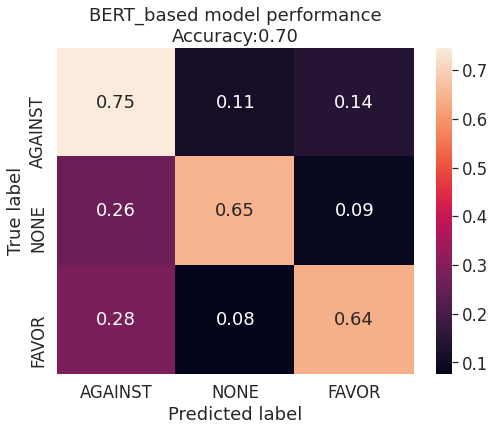

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
stance_set = ['AGAINST', 'NONE', 'FAVOR']
# Creates a confusion matrix
cm = confusion_matrix(y_test, y_pred) 

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Transform to df for easier plotting
labels = list(stance_dict.keys()) #['AGAINST', 'NONE', 'FAVOR']
print(stance_dict.values())
#labels = [ 'Informative','Uninformative','Not related']
cm_df = pd.DataFrame(cmn,
                     index = labels, 
                     columns = labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".2f")
#linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.title('BERT_based model performance\nAccuracy:{0:.2f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('confusion_matrix_info_type.png', dpi=300, bbox_inches='tight')
plt.savefig('confusion_matrix_informative.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:

n = len(target_y_pred)
pred_for_target = [[] for i in target_set]
test_for_target = [[] for i in target_set]


for i in range(n):
    pred_for_target[target_y_test[i]].append(y_pred[i])
    test_for_target[target_y_test[i]].append(y_test[i])

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.784978 0.588933 0.615142]
recall: [0.745455 0.647826 0.641447]
fscore: [0.764706 0.616977 0.628019]
support: [715 230 304]


In [ ]:
(fscore[2]+fscore[0])/2

0.6963626030122194

In [ ]:
import numpy as np
Macro_avg = []
for i in range(len(target_set)):
    print(target_set[i])
    precision, recall, fscore, support = score(test_for_target[i], pred_for_target[i])
    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
    print('fscore: {}'.format(fscore))
    print('support: {}'.format(support))
    print('ave f-1: {}\n'.format((fscore[0]+fscore[2])/2))
    Macro_avg.append((fscore[0]+fscore[2])/2)

ave = np.mean(Macro_avg)
print('macro-average: {}'.format(ave))

Feminist Movement
precision: [0.769231 0.557692 0.355556]
recall: [0.601093 0.659091 0.551724]
fscore: [0.674847 0.604167 0.432432]
support: [183  44  58]
ave f-1: 0.5536395290996518

Legalization of Abortion
precision: [0.833333 0.534483 0.5     ]
recall: [0.767196 0.688889 0.521739]
fscore: [0.798898 0.601942 0.510638]
support: [189  45  46]
ave f-1: 0.6547681847488425

Climate Change is a Real Concern
precision: [0.       0.675676 0.861538]
recall: [0.       0.714286 0.910569]
fscore: [0.       0.694444 0.885375]
support: [ 11  35 123]
ave f-1: 0.4426877470355731

Atheism
precision: [0.825301 0.5      0.454545]
recall: [0.85625  0.571429 0.3125  ]
fscore: [0.840491 0.533333 0.37037 ]
support: [160  28  32]
ave f-1: 0.6054305839581913

Hillary Clinton
precision: [0.726804 0.648649 0.62963 ]
recall: [0.819767 0.615385 0.377778]
fscore: [0.770492 0.631579 0.472222]
support: [172  78  45]
ave f-1: 0.6213570127504554

macro-average: 0.5755766115185429


Feminist Movement
dict_values([0, 1, 2])


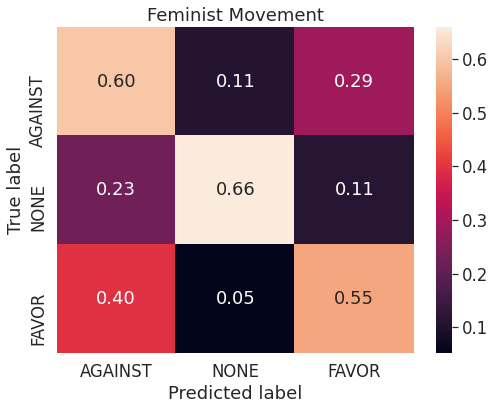

Legalization of Abortion
dict_values([0, 1, 2])


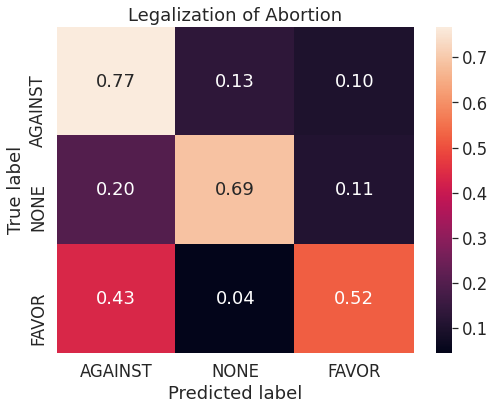

Climate Change is a Real Concern
dict_values([0, 1, 2])


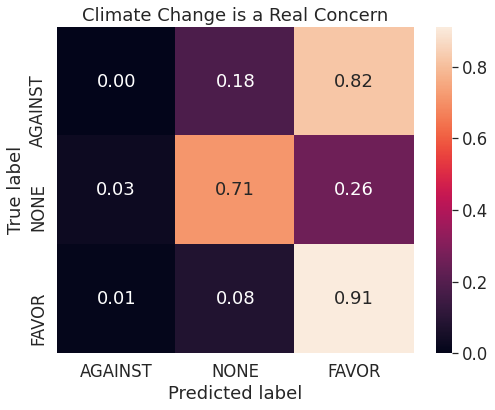

Atheism
dict_values([0, 1, 2])


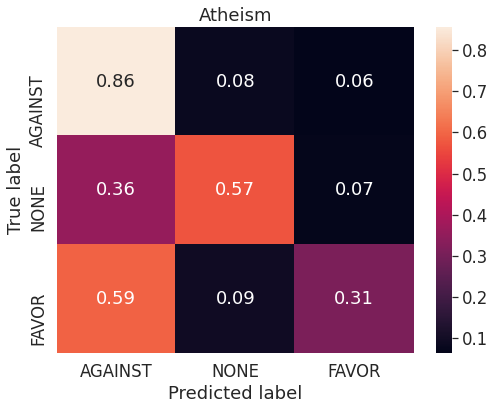

Hillary Clinton
dict_values([0, 1, 2])


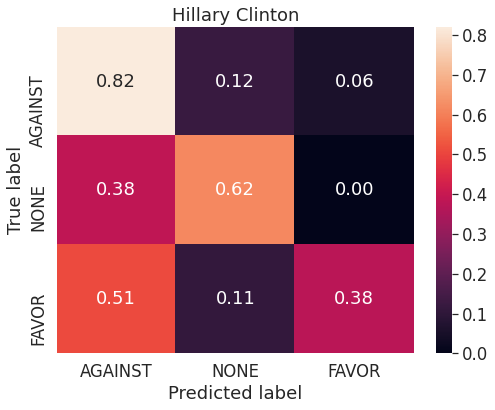

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
for i in range(len(target_set)):
    print(target_set[i])
    precision, recall, fscore, support = score(test_for_target[i], pred_for_target[i])

    # Creates a confusion matrix
    cm = confusion_matrix(test_for_target[i], pred_for_target[i]) 

    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Transform to df for easier plotting
    labels = stance_set
    #labels = target_set
    print(stance_dict.values())

    cm_df = pd.DataFrame(cmn,
                        index = labels, 
                        columns = labels)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm_df, annot=True,fmt=".2f")
    #linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
    plt.title('{}'.format(target_set[i]))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.savefig('confusion_matrix_info_type.png', dpi=300, bbox_inches='tight')
    plt.savefig('confusion_matrix_informative.png', dpi=300, bbox_inches='tight')
    plt.show()

Accuracy on the CoLA benchmark is measured using the "[Matthews correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)" (MCC).

We use MCC here because the classes are imbalanced:


In [ ]:
#print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches. 

Each batch has 32 sentences in it, except the last batch which has only (516 % 32) = 4 test sentences in it.


In [ ]:
#matthews_set

In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.496
